In [460]:
import os

proj_dir = '/Users/nickbachelder/Desktop/Kaggle/Linemen'
os.chdir( os.path.join(proj_dir, 'code/objects') )

%run load_modules.ipynb
%run tracking_objects.ipynb

In [165]:
data_dir = os.path.join(proj_dir, 'data' )
os.chdir( proj_dir )
os.system("rm -rf {}".format( data_dir ))
os.system('mkdir data')
os.chdir( data_dir )
os.system("kaggle competitions download -c nfl-big-data-bowl-2023")
os.system( 'unzip {}.zip'.format( os.path.join(data_dir, 'nfl-big-data-bowl-2023')) )

curr_cd = os.getcwd()
files = [x for x in os.listdir(curr_cd) if os.path.isfile(os.path.join(curr_cd, x))]

player_files = [os.path.join(curr_cd, x) for x in files if x.endswith('players.csv')]
player_tracking_files = [os.path.join(curr_cd, x) for x in files if x.startswith('week')]
play_details_files = [os.path.join(curr_cd, x) for x in files if x.endswith('ScoutingData.csv')]
play_info_files = [os.path.join(curr_cd, x) for x in files if x.endswith('plays.csv')]


 99%|█████████▉| 171M/172M [00:13<00:00, 13.9MB/s] 


Archive:  /Users/nickbachelder/Desktop/Kaggle/Linemen/data/nfl-big-data-bowl-2023.zip
  inflating: games.csv               
  inflating: pffScoutingData.csv     
  inflating: players.csv             
  inflating: plays.csv               
  inflating: week1.csv               

100%|██████████| 172M/172M [00:13<00:00, 13.4MB/s]



  inflating: week2.csv               
  inflating: week3.csv               
  inflating: week4.csv               
  inflating: week5.csv               
  inflating: week6.csv               
  inflating: week7.csv               
  inflating: week8.csv               


In [461]:
all_data = master_track(track_paths = player_tracking_files, 
                            play_info_path = play_info_files[0],
                            play_details_path = play_details_files[0],
                            players_path = player_files[0])

In [462]:
all_data.load_training_data(week = 2)

Getting week 1 training data


100%|██████████| 1172/1172 [05:50<00:00,  3.35it/s]


Done


In [467]:
all_data.get_averages_up_to_week(week = 2)

Getting week 1 average metrics by position and blocker number
Done


In [468]:
training_dat_week_2 = all_data.split_training_times(week = 2, normalize = False)

Getting week 1 normalized training data
Done


In [427]:
# sack / hurry / hit are dependent on both pass coverage and lineman and we only care about linemen. 
# Instead of using sack / hit /hurry, use P(Sack, Hurry, Hit @ time t) given conditions for team
# to evaluate players, need some sort of metric for 'contribution to P(Sack, Hurry, Hit @ time t) on play'
# to do so try to do  or sommin    [ P(Sack, Hurry, Hit @ time t replacing player with rusher average) / P(Sack, Hurry, Hit @ time t) ] - P(Sack, Hurry, Hit @ time t)




# new idea: since there is no team level time of sack
# find model that we can track each player prob of hit/hurry/sack 
# each player route will have a prob of sack at time t. 
# to compare use average route stats in similar situation: note may have to import more data (ie. play type etc)


# also: need to create qb_metric for 'facing rusher' 



In [389]:
train_week_1 = all_data.training_data_team.get('1')

import plotly.express as px

px.line(train_week_1, x='time_after_snap', y="rusher_distance_from_qb_min", color="disrupt_team")

In [1062]:







# this is old, delete when done w it



week = 3

all_dist_dfs = []
needed_weeks = list(range(1, week))
for each_week in needed_weeks:
    print(f'Getting week {each_week} average metrics')
    # if (str(each_week) in all_data.track_dfs.keys()) and not (all_data.overall_avgs.get(str(each_week)) is None) :
    #    next
    #else:
    if True:
        all_dist_dfs = []
        plays_this_week = np.unique(all_data.track_dfs.get(str(each_week)).playId).tolist()
        for play_id in tqdm.tqdm(plays_this_week[1:10]):
            dist_df = all_data.get_rusher_distances_from_qb_on_play(play_id = play_id, output = False)
            if type(dist_df) is type(None):
                continue # in case of no rushers
            all_dist_dfs.append(dist_df)
        all_dist_dfs = pd.concat(all_dist_dfs)












        this_week_sample_sizes = all_dist_dfs.loc[:, ['time_after_snap']].groupby(by = ['time_after_snap']).size().reset_index(name = 'counts').rename(columns = {'counts' : 'play_sample_size_for_league_avgs'} )
        this_week_sd = all_dist_dfs.loc[:, ['time_after_snap', 'rusher_distance_from_qb', 'rusher_distance_toward_qb_gained']].groupby(by = ['time_after_snap']).var().reset_index().rename(columns = {'rusher_distance_from_qb' : 'rusher_distance_from_qb_var', 
                                                                                                                                                                                                        'rusher_distance_toward_qb_gained' : 'rusher_distance_toward_qb_var'})
        this_week_sd['rusher_distance_from_qb_std_dev'] = np.sqrt(this_week_sd.rusher_distance_from_qb_var)
        this_week_sd['rusher_distance_toward_qb_std_dev'] = np.sqrt(this_week_sd.rusher_distance_toward_qb_var)
        this_week_avs = all_dist_dfs.loc[:, ['time_after_snap', 'rusher_distance_toward_qb_gained']].query("time_after_snap >= 0").groupby(by = ['time_after_snap']).mean().reset_index()
        this_week_avs = this_week_avs.merge(this_week_sample_sizes, on = 'time_after_snap', how = 'left').copy()
        this_week_avs = this_week_avs.merge(this_week_sd, on = 'time_after_snap', how = 'left').copy()

        if not (each_week == 1):
            old_averages = all_data.overall_avgs.get(str(each_week - 1)).copy()
            this_week_avs = this_week_avs.loc[this_week_avs.time_after_snap <= all_data.max_time_after_snap]
            append_later = False
            if this_week_avs.shape[0] < old_averages.shape[0]:
                missing_time_after = list(set(old_averages.time_after_snap).difference(this_week_avs.time_after_snap))
                old_averages_stay_the_same = old_averages.loc[old_averages.time_after_snap.isin(missing_time_after)]
                old_averages = old_averages.loc[~(old_averages.time_after_snap.isin(missing_time_after))].copy()
                append_later = True

            this_week_avs_list = this_week_avs.rusher_distance_toward_qb_gained.copy().tolist()
            old_averages_list = old_averages.rusher_distance_to_qb_gained_league_avg.copy().tolist()
            this_week_avs_sample_size_list = this_week_avs.play_sample_size_for_league_avgs.copy().tolist()
            old_averages_sample_size_list = old_averages.play_sample_size_for_league_avgs.copy().tolist()
            this_week_avs_var_list = this_week_avs.rusher_distance_toward_qb_var.copy().tolist()
            old_averages_var_list = this_week_avs.rusher_distance_toward_qb_var.copy().tolist()

            distance_this_week_avs_list = this_week_avs.rusher_distance_from_qb.copy().tolist()
            distance_old_averages_list = old_averages.rusher_distance_to_qb_gained_league_avg.copy().tolist()
            distance_this_week_avs_sample_size_list = this_week_avs.play_sample_size_for_league_avgs.copy().tolist()
            distance_old_averages_sample_size_list = old_averages.play_sample_size_for_league_avgs.copy().tolist()
            distance_this_week_avs_var_list = this_week_avs.rusher_distance_toward_qb_var.copy().tolist()
            distance_old_averages_var_list = this_week_avs.rusher_distance_toward_qb_var.copy().tolist()


            new_averages_num = (np.array(this_week_avs_sample_size_list) * np.array(this_week_avs_list) + np.array(old_averages_sample_size_list) * np.array(old_averages_list))
            new_averages_denom = (np.array(this_week_avs_sample_size_list) + np.array(old_averages_sample_size_list))

            new_var_num = (np.array(this_week_avs_sample_size_list) * np.array(this_week_avs_var_list) + np.array(old_averages_sample_size_list) * np.array(old_averages_var_list))

            new_averages = (new_averages_num / new_averages_denom).tolist()
            new_var = (new_var_num / new_averages_denom).tolist()
            new_std_dev = np.sqrt(new_var)

            old_averages.rusher_distance_to_qb_gained_league_avg =  new_averages
            old_averages.play_sample_size_for_league_avgs =  new_averages_denom
            old_averages.rusher_distance_toward_qb_var =  new_var
            old_averages.rusher_distance_toward_qb_std_dev =  new_std_dev

            if append_later == True:
                old_averages = pd.concat([old_averages, old_averages_stay_the_same])
            curr_avs = old_averages

        else:
            curr_avs = this_week_avs
            curr_avs = curr_avs.loc[this_week_avs.time_after_snap <= all_data.max_time_after_snap]
            curr_avs.rename({'rusher_distance_toward_qb_gained': 'rusher_distance_to_qb_gained_league_avg'}, axis=1, inplace=True)

        tracking_data = all_data.track_dfs.get(str(each_week))
        results_data = all_data.play_details_df.fillna(0)
        results_data.loc[:,"hit_hurry_sack"] = results_data['pff_hit'] + results_data['pff_hurry'] + results_data['pff_sack'] + results_data['pff_hitAllowed'] + results_data['pff_hurryAllowed'] + results_data['pff_sackAllowed']
        results_data = results_data.loc[:, ['nflId', 'playId', 'hit_hurry_sack']]

        training_df = all_dist_dfs.merge(tracking_data, on = ['playId', 'nflId', 'time_after_snap'], how = 'left')
        training_df = training_df.merge(results_data, on = ['nflId', 'playId'], how = 'left')
        training_df = training_df.merge(curr_avs, on = ['time_after_snap'], how = 'left')
        training_df = training_df.loc[training_df['time_after_snap'] >= 0]
        training_df['metric'] = ((training_df.rusher_distance_toward_qb_gained - training_df.rusher_distance_to_qb_gained_league_avg) / (training_df.rusher_distance_toward_qb_std_dev)).fillna(0)
        training_df = training_df.loc[:, ['week', 'gameId', 'team', 'playId', 'nflId', 'time_after_snap', 'rusher_distance_toward_qb_gained', 'rusher_distance_to_qb_gained_league_avg', 'rusher_distance_toward_qb_std_dev', 'play_sample_size_for_league_avgs', 'metric', 'hit_hurry_sack', 'x', 'y']]


        all_data.training_data[str(each_week)] = training_df
        all_data.overall_avgs[str(each_week)] = curr_avs

Getting week 1 average metrics


100%|██████████| 9/9 [00:00<00:00, 12.50it/s]


KeyError: "Column(s) ['duration'] do not exist"

In [814]:
all_data.training_data.get('3')

In [1335]:
play_dets = all_data.play_details_df
play_dets['disrupt'] = play_dets.pff_hit + play_dets.pff_hurry + play_dets.pff_sack
print( f'Percent of player play disruptions: {play_dets.disrupt.sum() / len(play_dets.disrupt)}')
team_dets = play_dets.groupby('playId').agg({'disrupt' : [sum]})
team_dets.columns = ["_".join(x) for x in np.array(team_dets.columns).ravel()]
team_dets = team_dets.reset_index()
print( f'Percent of team play disruptions: {len(team_dets.loc[team_dets.disrupt_sum > 0]) / len(team_dets)}')

Percent of player play disruptions: 0.022958343514613237
Percent of team play disruptions: 0.37583265163024426


In [766]:
all_data.overall_avgs.get('4')

,time_after_snap,rusher_distance_to_qb_gained_league_avg,play_sample_size_for_league_avgs,rusher_distance_toward_qb_var,rusher_distance_toward_qb_std_dev
0,0.0,0.000000,19028,0.000000,0.000000
1,0.1,0.030554,19028,0.001646,0.040571
2,0.2,0.076341,19028,0.007434,0.086221
3,0.3,0.140239,19028,0.019915,0.141119
4,0.4,0.220577,19028,0.042241,0.205527
...,...,...,...,...,...
66,6.6,-2.611520,469,34.507965,5.874348
67,6.7,-2.662936,393,36.667348,6.055357
68,6.8,-2.615219,354,36.380929,6.031661
69,6.9,-2.363691,329,36.431778,6.035874


In [792]:
# code for player play average
all_train_this_week = all_data.training_data.get('1').copy()
all_train_this_week.loc[all_train_this_week.playId == 202109090097][1:50]

,week,gameId,team,playId,nflId,time_after_snap,rusher_distance_toward_qb_gained,rusher_distance_to_qb_gained_league_avg,rusher_distance_toward_qb_std_dev,play_sample_size_for_league_avgs,metric,hit_hurry_sack,x,y
1,1,2021090900,DAL,202109090097,41263.0,0.1,0.035527,0.029718,0.043049,4988.0,0.134933,1.0,43.19,18.91
2,1,2021090900,DAL,202109090097,41263.0,0.2,0.106890,0.075850,0.092114,4988.0,0.336970,1.0,43.03,18.93
3,1,2021090900,DAL,202109090097,41263.0,0.3,0.198946,0.140548,0.150097,4988.0,0.389068,1.0,42.87,18.98
4,1,2021090900,DAL,202109090097,41263.0,0.4,0.397456,0.220437,0.218069,4988.0,0.811757,1.0,42.60,19.09
5,1,2021090900,DAL,202109090097,41263.0,0.5,0.574331,0.310751,0.295906,4988.0,0.890754,1.0,42.34,19.20
6,1,2021090900,DAL,202109090097,41263.0,0.6,0.707938,0.405823,0.384826,4988.0,0.785068,1.0,42.12,19.29
7,1,2021090900,DAL,202109090097,41263.0,0.7,0.893711,0.499253,0.485309,4988.0,0.812798,1.0,41.90,19.50
8,1,2021090900,DAL,202109090097,41263.0,0.8,1.027011,0.587241,0.596928,4988.0,0.736721,1.0,41.66,19.69
9,1,2021090900,DAL,202109090097,41263.0,0.9,1.197933,0.668229,0.718448,4988.0,0.737289,1.0,41.42,19.90
10,1,2021090900,DAL,202109090097,41263.0,1.0,1.354812,0.741153,0.850072,4988.0,0.721891,1.0,41.18,20.13


In [645]:
# code for return_team_game_model_training, finsih later

all_train_this_week = all_data.training_data.get('2').copy()
all_train_this_week

training_dat = np.empty(shape = (num_play, all_num_player, num_time_after_snap, ))
for play_id in all_train_this_week.playId.unique():
    play_df = all_train_this_week.loc[all_train_this_week.playId == play_id]
    for player_id in play_df.nflId.unique():
        player_play_df = play_df.loc[play_df.nflId == player_id]
        player_play_df.metric
        



,week,gameId,team,playId,nflId,time_after_snap,rusher_distance_toward_qb_gained,rusher_distance_to_qb_gained_league_avg,metric,hit_hurry_sack,x,y
0,2,2021091600,NYG,202109160065,42349.0,0.0,0.000000,0.000000,0.000000,0.0,33.62,32.22
1,2,2021091600,NYG,202109160065,42349.0,0.1,0.000000,0.029453,0.000000,0.0,33.62,32.22
2,2,2021091600,NYG,202109160065,42349.0,0.2,0.023960,0.074546,0.321411,0.0,33.60,32.23
3,2,2021091600,NYG,202109160065,42349.0,0.3,0.047851,0.137629,0.347681,0.0,33.57,32.23
4,2,2021091600,NYG,202109160065,42349.0,0.4,0.103204,0.217015,0.475560,0.0,33.52,32.23
...,...,...,...,...,...,...,...,...,...,...,...,...
166553,2,2021092000,GB,20210920003759,47933.0,4.6,2.099579,-0.491762,-4.269506,0.0,71.94,33.16
166554,2,2021092000,GB,20210920003759,47933.0,4.7,2.398730,-0.562819,-4.261994,0.0,71.61,33.63
166555,2,2021092000,GB,20210920003759,47933.0,4.8,2.686764,-0.716106,-3.751910,0.0,71.27,34.10
166556,2,2021092000,GB,20210920003759,47933.0,4.9,2.955080,-0.850089,-3.476200,0.0,70.92,34.53


In [ ]:
# code for plotting movement

player_ids = all_data.search_track_weeks(variables = ["playId"], variable_values = [20210913004845]).reset_index(drop = True).nflId.unique()
player_ids = np.intersect1d(player_ids, all_data.all_linemen)
full_play_info = pd.DataFrame()
for player_id in player_ids:
    player_df = all_data.get_player_play(player_id, 20210913004845)
    full_play_info = pd.concat([full_play_info, player_df])
full_play_blockers = full_play_info.loc[full_play_info.Block_or_Rush == "Block"]
full_play_rushers = full_play_info.loc[full_play_info.Block_or_Rush == "Rush"]

n_frame = len(full_play_rushers.frameId.unique())
n_player_rush = len(full_play_rushers.nflId.unique())
n_player_block = len(full_play_blockers.nflId.unique())

motion_rush = np.empty(shape = (n_frame,3,n_player_rush))
motion_block = np.empty(shape = (n_frame,3,n_player_block))
for frame in range(n_frame):
    this_frame_rush = full_play_rushers.loc[full_play_rushers.frameId == frame + 1].copy()
    x_this_frame_rush, y_this_frame_rush, color_this_frame_rush = this_frame_rush.x.values.tolist(), this_frame_rush.y.values.tolist(), this_frame_rush.x.values.tolist()
    motion_rush[frame, :, :] = [x_this_frame_rush, y_this_frame_rush, color_this_frame_rush]
    
    this_frame_block = full_play_blockers.loc[full_play_blockers.frameId == frame + 1].copy()
    x_this_frame_block, y_this_frame_block, color_this_frame_block = this_frame_block.x.values.tolist(), this_frame_block.y.values.tolist(), this_frame_block.x.values.tolist()
    motion_block[frame, :, :] = [x_this_frame_block, y_this_frame_block, color_this_frame_block]

In [1096]:
range_x = [min(motion_rush[0,0,:]) - 3, max(motion_rush[0,0,:]) + 20]
range_y = [min(motion_rush[0,1,:]) - 5, max(motion_rush[0,1,:]) + 5]
color_min, color_max = np.amin(motion_rush[:,2,:]), np.amax(motion_rush[:,2,:])
start_frame = [go.Scatter(x=motion_rush[0,0,:], y = motion_rush[0,1,:], 
                            mode = "markers", 
                            name = "Rushers",
                            legendgroup = "Rushers",
                            marker = dict(size=16,color=motion_rush[0,2,:],colorscale='Greens',showscale=True, cmin=color_min, cmax = color_max)),
               go.Scatter(x=motion_block[0,0,:], y = motion_block[0,1,:], 
                            mode = "markers", 
                            name = "Blockers",
                            legendgroup = "Blockers",
                            marker = dict(size=16,color=motion_block[0,2,:],colorscale='Greens', showscale=True, cmin=color_min, cmax = color_max),
                            marker_symbol = "x"  )]

all_frame = [   go.Frame(data = [go.Scatter(x=vec[0][0], y = vec[0][1], 
                                            mode = "markers", 
                                            name = "Rushers",
                                            legendgroup = "Rushers",
                                            marker = dict(size=16,color=vec[0][2] ) ),
                                 go.Scatter(x=vec[1][0], y = vec[1][1], 
                                            mode = "markers", 
                                            name = "Blockers",
                                            legendgroup = "Blockers",
                                            marker = dict(size=16,color=vec[1][2]),
                                            marker_symbol = "x" ) ]) 
            for vec in zip(motion_rush[1:,:,:], motion_block[1:,:,:])  ]
layout_draw = go.Layout(
        xaxis=dict(range=range_x, autorange=False),
        yaxis=dict(range=range_y, autorange=False),
        title= f'Play {play_id}',
        updatemenus=[dict(type="buttons",
                        buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None, {"frame": {"duration": 100, "redraw": False}, "fromcurrent": True, "transition": {"duration": 0}}])])]
    )


In [1363]:
from __future__ import annotations
import plotly
import plotly.graph_objects as go
fig = go.Figure(
    data= start_frame,
    layout=layout_draw,
    frames=all_frame
)

fig.update_layout(legend=dict(orientation = "h"))  
fig.show()

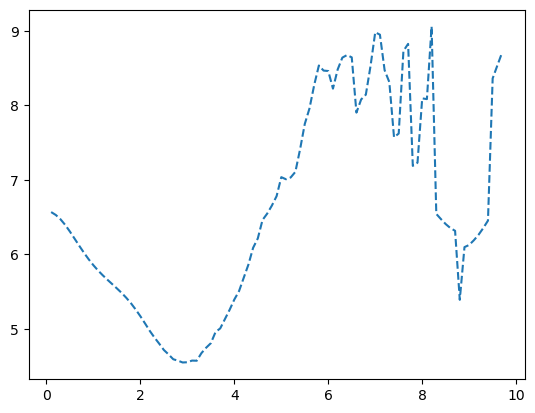

In [1205]:
import matplotlib.pyplot as plt
plot_overall_avgs = all_dist_dfs.query("time_after_snap > 0").groupby(by = ['time_after_snap']).mean().reset_index()

plt.title = "Average Rusher Distance From QB by Seconds After Snap"
plt.xlabel = "Seconds After Snap"
plt.plot('time_after_snap',  'rusher_distance_from_qb', data = plot_overall_avgs, linestyle='dashed')
plt.ylabel = "Rusher Distance From QB"
plt.show()

In [ ]:
### want to get groups of players with similar starting positions: conlusion: just use number of blockers on play for now, maybe add in weigt of blocker later

# this_week_starting_pos = all_data.training_data_individual.get('1')
# this_week_starting_pos = this_week_training_individual.loc[this_week_training_individual.time_after_snap == 0, ['playId', 'nflId', 'rusher_distance_from_qb', 'y']]



# gmm_train = this_week_starting_pos.drop(['playId', 'nflId'], axis = 1)
# gmm = mixture.GaussianMixture(n_components=2).fit(gmm_train)
# gmm_labels = gmm.predict(gmm_train).astype(str)

# this_week_starting_pos['starting_pos_class'] = gmm_labels
# this_week_starting_pos.groupby('starting_pos_class').groups.items()
# plot_df = this_week_starting_pos.drop(['playId', 'nflId'], axis = 1).reset_index(drop = 1)
# plot_df.starting_pos_class.unique()
# plot_df

# groups = plot_df.groupby('starting_pos_class')
# # Plot
# fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# for name, group in groups:
#     ax.plot(group.rusher_distance_from_qb, group.y, marker='o', linestyle='', ms=12, label=name)
# ax.legend()

# plt.show()

# ret_df = this_week_starting_pos.loc[:, ['playId', 'nflId', 'starting_pos_class']]
# ret_df